In [1]:
import os
import torch
# import numpy as np
import matplotlib.pyplot as plt
import torchio as tio
import torchvision
from trainer_org import LitTrainer
from generator import GeneratorRRDB
from discriminator import Discriminator
from feature_extractor import FeatureExtractor
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from collections import OrderedDict
import argparse
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.vgg as vgg
from dataset_tio import ImagePair, data_split, Normalize, calculate_overlap
from pytorch_lightning.loggers import TensorBoardLogger


print(os.getcwd())
torch.cuda.empty_cache()

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

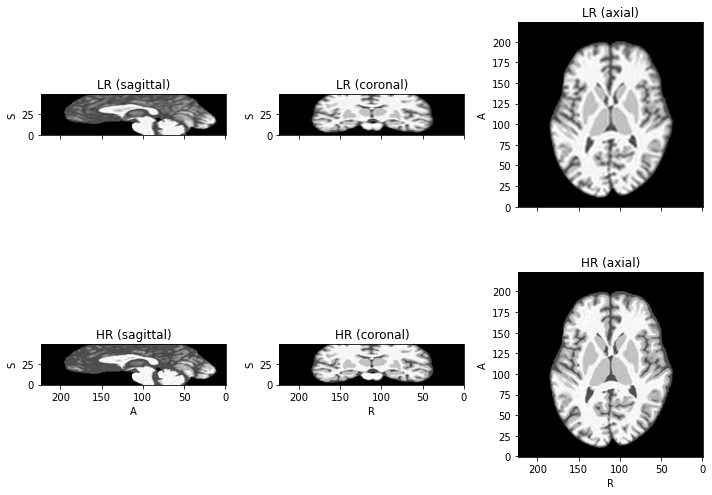

In [3]:
num = 100206
img = ImagePair(number=num, root_dir='data')
# img_slice = img.subject()['LR'].numpy()[0,:,:,25]
# plt.imshow(img_slice, cmap='gray')

img.subject().plot(figsize=(10,10))

In [4]:
train_subjects = data_split('training', patients_frac=.1)
val_subjects = data_split('validation', patients_frac=.1)

Loading training set...
Loading validation set...


In [114]:
std = 0.3548

training_transform = tio.Compose([
    tio.RandomNoise(
        p=0.5,
        mean=0,
        std=.1
    ),
    tio.RandomGamma(
        p=.5,
        log_gamma=0.3,
    ),
    tio.RandomSpike(
        p=.5,
        num_spikes=3,
        intensity=.2,
    ),
    tio.RandomSwap(
        p=0.2,
        patch_size=int(0.1*224),
        num_iterations=4,
    ),
    tio.RandomFlip(),
    Normalize(std=std),
])

training_set = tio.SubjectsDataset(
    train_subjects, transform=training_transform)

val_set = tio.SubjectsDataset(
    val_subjects, transform=None)


In [115]:
batch_size = 32
training_batch_size = batch_size
validation_batch_size = batch_size

num_workers = 4
patch_size = (224,224)
ovl_perc = (.5, .5)
overlap, nr_patches = calculate_overlap(train_subjects[0]['LR'], patch_size, ovl_perc)
samples_per_volume = nr_patches

max_queue_length = samples_per_volume*100
sampler = tio.data.GridSampler(patch_size=(*patch_size,1), patch_overlap=overlap)#, padding_mode=0)

training_queue = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

val_queue = tio.Queue(
    subjects_dataset=val_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    training_queue, batch_size=training_batch_size)

val_loader = torch.utils.data.DataLoader(
    val_queue, batch_size=training_batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 224, 224])


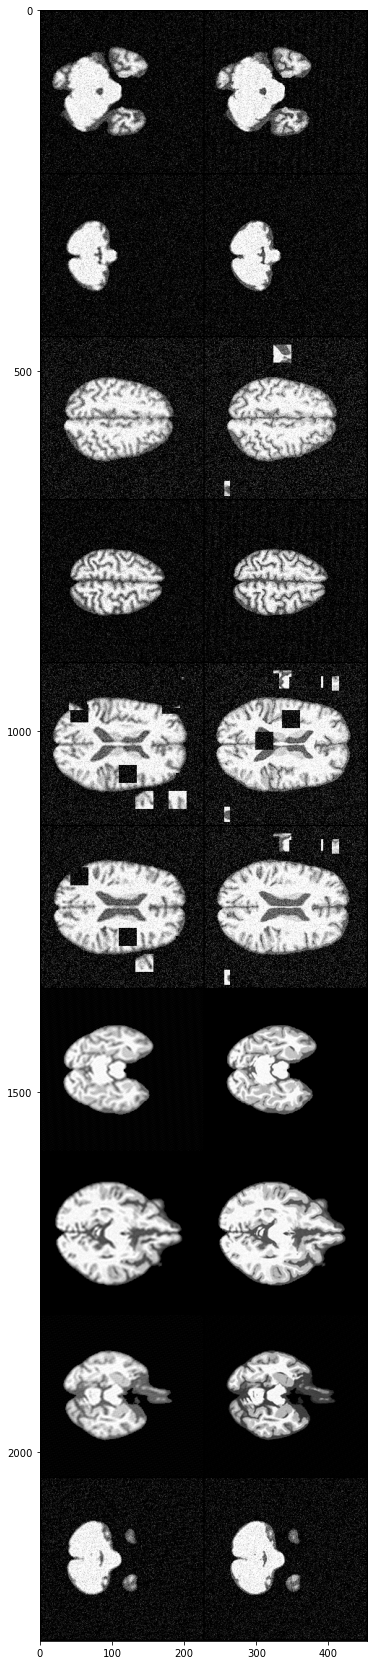

In [116]:
batch = next(iter(training_loader))

lr = batch['LR'][tio.DATA][:10]*std
hr = batch['HR'][tio.DATA][:10]*std

grid = torch.cat([torch.stack([a_row,b_row]) for a_row, b_row in zip(lr.squeeze(),hr.squeeze())]).unsqueeze(1)

print(grid.shape)
grid_img = torchvision.utils.make_grid(grid, nrow=2)

plt.figure(figsize=(10,30))
plt.imshow(grid_img.permute(1, 2, 0))

In [51]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1,64,64))
# feature_extractor = FeatureExtractor().to(device)

In [52]:
logger = TensorBoardLogger("log", name="meuk", default_hp_metric=False)
# logger.log_metrics('tensorboard_logs')

model = LitvTrainer(netG=generator, netD=discriminator)
trainer = pl.Trainer(gpus=1, max_epochs=3, logger=logger, log_every_n_steps=10)#, strategy='ddp')
trainer.fit(model, train_dataloaders=training_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3,4]

  | Name            | Type          | Params
--------------------------------------------------
0 | netG            | GeneratorRRDB | 445 K 
1 | netD            | Discriminator | 4.7 M 
2 | criterion_GAN   | GANLoss       | 0     
3 | criterion_pixel | L1Loss        | 0     
--------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.551    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[[{'loss': tensor(1.1424, device='cuda:0')}, {'loss': tensor(1.1769, device='cuda:0')}, {'loss': tensor(1.1167, device='cuda:0')}, {'loss': tensor(1.0563, device='cuda:0')}, {'loss': tensor(1.0655, device='cuda:0')}, {'loss': tensor(0.9700, device='cuda:0')}, {'loss': tensor(0.9956, device='cuda:0')}, {'loss': tensor(0.9170, device='cuda:0')}, {'loss': tensor(0.9862, device='cuda:0')}, {'loss': tensor(0.9649, device='cuda:0')}, {'loss': tensor(0.9240, device='cuda:0')}, {'loss': tensor(0.9859, device='cuda:0')}, {'loss': tensor(0.9121, device='cuda:0')}, {'loss': tensor(0.9529, device='cuda:0')}, {'loss': tensor(1.0124, device='cuda:0')}, {'loss': tensor(1.0175, device='cuda:0')}, {'loss': tensor(0.9557, device='cuda:0')}, {'loss': tensor(1.0338, device='cuda:0')}, {'loss': tensor(0.8970, device='cuda:0')}, {'loss': tensor(1.0093, device='cuda:0')}, {'loss': tensor(0.9091, device='cuda:0')}, {'loss': tensor(0.9799, device='cuda:0')}, {'loss': tensor(1.0054, device='cuda:0')}, {'loss': 

Validating: 0it [00:00, ?it/s]

[[{'loss': tensor(0.9194, device='cuda:0')}, {'loss': tensor(0.8621, device='cuda:0')}, {'loss': tensor(0.8949, device='cuda:0')}, {'loss': tensor(0.7861, device='cuda:0')}, {'loss': tensor(0.8413, device='cuda:0')}, {'loss': tensor(0.8818, device='cuda:0')}, {'loss': tensor(0.8285, device='cuda:0')}, {'loss': tensor(0.7912, device='cuda:0')}, {'loss': tensor(0.7793, device='cuda:0')}, {'loss': tensor(0.9125, device='cuda:0')}, {'loss': tensor(0.8722, device='cuda:0')}, {'loss': tensor(0.7653, device='cuda:0')}, {'loss': tensor(0.8331, device='cuda:0')}, {'loss': tensor(0.8004, device='cuda:0')}, {'loss': tensor(0.8669, device='cuda:0')}, {'loss': tensor(0.7992, device='cuda:0')}, {'loss': tensor(0.8291, device='cuda:0')}, {'loss': tensor(0.8267, device='cuda:0')}, {'loss': tensor(0.7948, device='cuda:0')}, {'loss': tensor(0.8372, device='cuda:0')}, {'loss': tensor(0.8588, device='cuda:0')}, {'loss': tensor(0.7571, device='cuda:0')}, {'loss': tensor(0.8449, device='cuda:0')}, {'loss': 

Validating: 0it [00:00, ?it/s]

[[{'loss': tensor(1.0341, device='cuda:0')}, {'loss': tensor(0.8052, device='cuda:0')}, {'loss': tensor(0.8575, device='cuda:0')}, {'loss': tensor(1.1687, device='cuda:0')}, {'loss': tensor(0.8873, device='cuda:0')}, {'loss': tensor(0.7634, device='cuda:0')}, {'loss': tensor(0.9300, device='cuda:0')}, {'loss': tensor(0.8920, device='cuda:0')}, {'loss': tensor(0.8372, device='cuda:0')}, {'loss': tensor(0.9323, device='cuda:0')}, {'loss': tensor(0.9115, device='cuda:0')}, {'loss': tensor(0.9532, device='cuda:0')}, {'loss': tensor(0.7860, device='cuda:0')}, {'loss': tensor(0.8768, device='cuda:0')}, {'loss': tensor(0.9266, device='cuda:0')}, {'loss': tensor(0.8610, device='cuda:0')}, {'loss': tensor(0.7514, device='cuda:0')}, {'loss': tensor(0.8571, device='cuda:0')}, {'loss': tensor(0.8441, device='cuda:0')}, {'loss': tensor(0.8941, device='cuda:0')}, {'loss': tensor(0.8133, device='cuda:0')}, {'loss': tensor(0.8035, device='cuda:0')}, {'loss': tensor(0.8531, device='cuda:0')}, {'loss': 